## Data Cleaning and Exploratory Data Analysis:

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# standard imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gp
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# modelling and processing imports

from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise.prediction_algorithms import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [4]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white' # or EAEAF2
plt.rcParams['font.size'] = 16

In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

parent_dir = '../../'

from src import recommender as rec
from src import content_rec as cr

## Get the Data

The data used for this project is from GroupLens and is called the MovieLens Dataset.  You can find all the details of this dataset and download the appropriate data files yourself [here](https://grouplens.org/datasets/movielens/latest/).  

Alternatively, you can click [this link](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) to download the zip file of the data files used in this project (1MB).  This zip file contains 4 csv files:  `movies`, `ratings`, `tags` and `links`.  See the README.md in the [data](../../data) folder for more info on how this data is formatted.  On the website provided above,  you also have access to the 'large' dataset which is 256MB and was not used in this project.  Download from their website at your own will.  

The four csv datasets were downloaded to this repo which you can find [here](../../data) - they are labelled `movies.csv`, `links.csv`, `ratings.csv` and `tags.csv`.  If you're following along in this notebook, the cells below will run as we import these csv's using pandas.  Let's get to it!

In [6]:
# load in 4 datasets:
ratings = pd.read_csv(parent_dir + 'data/ratings.csv')

movies = pd.read_csv(parent_dir + 'data/movies.csv')

tags = pd.read_csv(parent_dir + 'data/tags.csv')

links = pd.read_csv(parent_dir + 'data/links.csv')

## Exploratory Data Analysis

It should be noted that each group member performed their own EDA in their own way.  Please refer to each member's individual exploratory notebooks which you can find [here](../exploratory), for more details on individual findings and explorations.  What will be detailed here is a summary of all of our EDA efforts combined.  

We'll start by exploring each dataset and then aggregate as necessary as we go. 

### Ratings Dataset

Let's first start by looking into the `ratings` dataset:

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Check how many unique movies we have:

In [8]:
len(ratings.movieId.unique())

9724

Check how many unique ratings we have to make sure we don't have any weird values:

In [9]:
print(f"Number of ratings: {len(ratings.rating.unique())}")
print(f"Possible rating values:  {ratings.rating.unique()}")

Number of ratings: 10
Possible rating values:  [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


All these numbers are reasonable and expected.  We can see that we have a 10 point scale from 0.5 - 5 so half ratings are included and 0 is not included. 

Let's check data types and null values:

In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


We do not appear to have any missing values and all data types seem reasonable.  While we won't use the timestamp column for modelling (this will be dropped), we may want to investigate timeseries information later so we will transform this column to a datetime object:

In [11]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1970-01-01 00:00:00.964982703
1,1,3,4.0,1970-01-01 00:00:00.964981247
2,1,6,4.0,1970-01-01 00:00:00.964982224
3,1,47,5.0,1970-01-01 00:00:00.964983815
4,1,50,5.0,1970-01-01 00:00:00.964982931


As mentioned in the documentation, `timestamp` is seconds since 1970.  

Let's investigate some more details of the dataframe.  How many users do we have in this dataset?

In [13]:
print(f"Number of users: {len(ratings.userId.unique())}")

Number of users: 610


What's the average rating?

In [14]:
print(f"Average rating:  {ratings.rating.mean()}")

Average rating:  3.501556983616962


So we have an average rating that is just above the median rating (2.5).  Let's have a look at the distribution of the ratings:

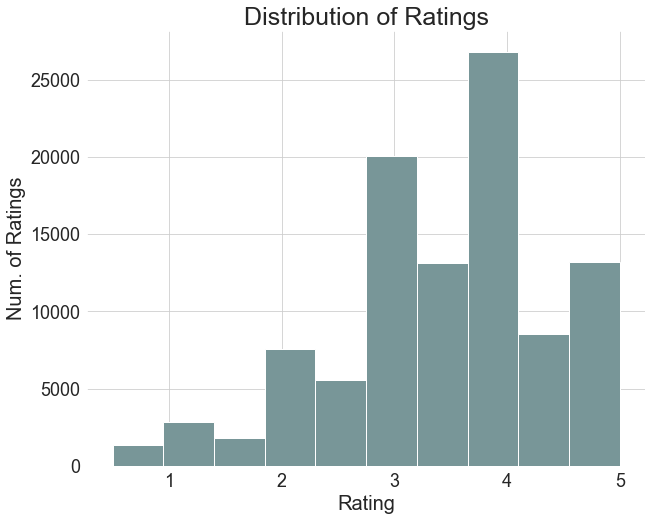

In [15]:
plt.subplots(figsize = (10, 8))
plt.hist(ratings.rating, bins = 10, color = '#789698')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Num. of Ratings')
plt.savefig(parent_dir + 'reports/figures/dist_ratings.png')
plt.show();

We see again here that the average rating is around 3.5 and the data is left-skewed.  This shows us that there aren't many low ratings between 0.5 and 2.  Perhaps this says something about the motivation for people to rate movies - perhaps people don't bother if the movie is bad...

Let's have a look at the average rating per movies and view this distribution:

In [16]:
rated = pd.DataFrame(ratings.groupby(['movieId'])['rating'].mean())

In [17]:
rated.sort_values('rating', ascending = False, inplace = True)

Let's also find the number of ratings for each movie and add it to our new dataframe:

In [18]:
rated['num_rating'] = pd.DataFrame(ratings.groupby(['movieId'])['rating'].count())
rated.head()

,rating,num_rating
movieId,,
88448,5.0,1
100556,5.0,1
143031,5.0,1
143511,5.0,1
143559,5.0,1


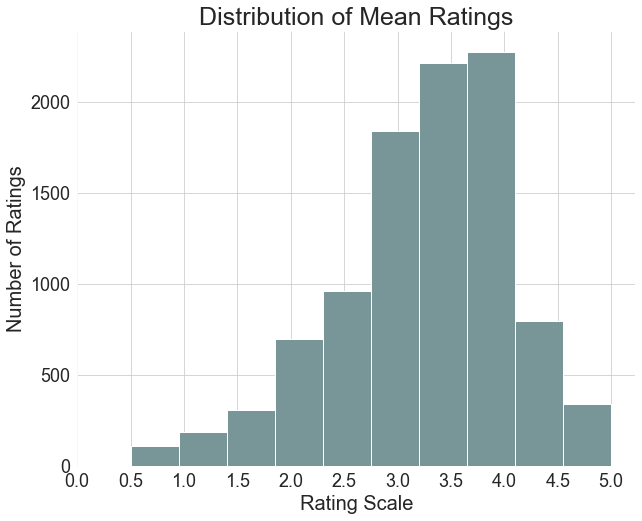

In [19]:
fig = plt.subplots(figsize=(10,8))
plt.hist(rated.rating, bins = 10, color = '#789698')
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.title('Distribution of Mean Ratings')
plt.xlabel('Rating Scale')
plt.ylabel('Number of Ratings')
plt.savefig(parent_dir + 'reports/figures/dist_mean_ratings.png')
plt.show();

We see a similar shape here again. 

### Investigating the Longtail Problem:

Something that comes up a lot in recommendation system problems is the long tail problem.  This is where we have a fast majority of users and/or items that only have 1 rating associated to them and a small amount of items/users that have a lot of ratings associated with them.  Let's first look into the number of ratings per movie:

In [20]:
# group ratings by movie and count the number of ratings per movie
num_ratings = ratings.groupby('movieId').count().drop('userId', axis = 1)

In [21]:
# sort these ratings
sorted_num_ratings = num_ratings.sort_values(by = 'rating', axis = 0, ascending = False)

In [22]:
sorted_num_ratings

,rating,timestamp
movieId,,
356,329,329
318,317,317
296,307,307
593,279,279
2571,278,278
...,...,...
4093,1,1
4089,1,1
58351,1,1


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


KeyboardInterrupt: 

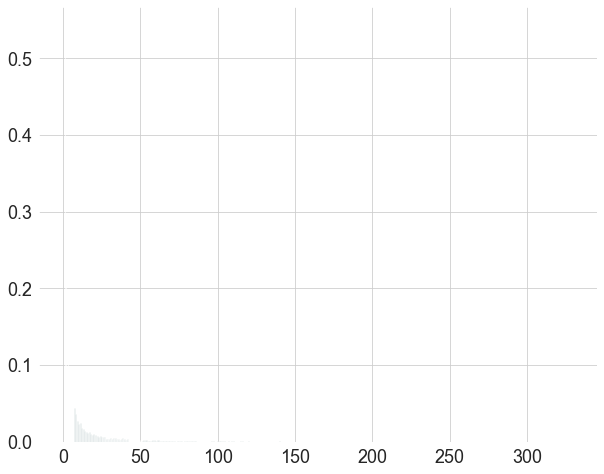

In [26]:
plt.subplots(figsize = (10, 8))
sns.distplot(sorted_num_ratings, bins = 500, color = ['#789698', '#789698'])
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Num. of Ratings per Movie')
plt.savefig(parent_dir + 'reports/figures/ratings_by_movie.png')
plt.show();

As you can see we do have a long tail problem here where the majority of movies have less than 25 ratings and very few have more than that.  

Let's now look into the number of ratings per user to investigate this long tail problem further:

In [168]:
movies.head()

,movieId,title,genres,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


In [169]:
users = pd.DataFrame(ratings.groupby(['userId'])['rating'].count())

In [172]:
users.shape

(610, 1)

In [173]:
users.sort_values('rating', ascending=False)[:20]

,rating
userId,
414,2698
599,2478
474,2108
448,1864
274,1346
610,1302
68,1260
380,1218
606,1115


The "top 12" users have each rated over 1000 movies.

In [174]:
users.sort_values('rating', ascending=True)[:75]

,rating
userId,
442,20
406,20
147,20
194,20
569,20
...,...
258,25
228,25
150,26


On the flip side around 75 users have rated 25 movies or fewer

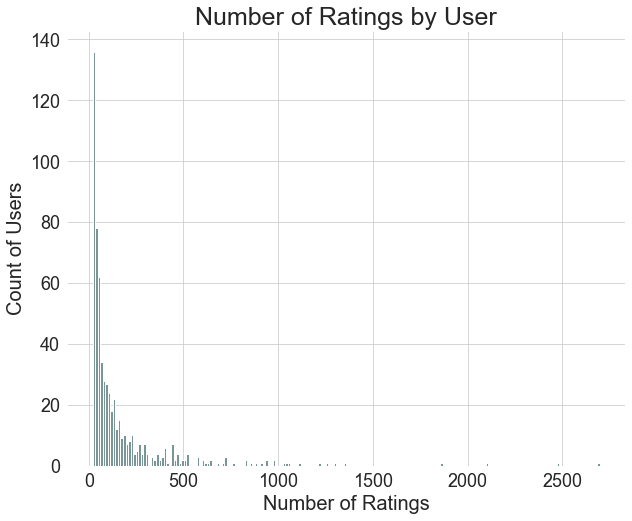

In [177]:
fig = plt.subplots(figsize=(10,8))
plt.hist(users.rating, bins = 200, color = '#789698')
plt.title('Number of Ratings by User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.savefig(parent_dir + 'reports/figures/ratings_by_user.png')
plt.show();

Again, we can see the long tail problem playing out here.  This will have to be addressed with regularisation in our modelling.  

Let's now look into the movies dataset:

### Movies Dataset

Let's begin by looking at a preview of our data as always.

In [67]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


And let's inspect the datatypes and null values:

In [68]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


So from here we assume there are 9742 unique movies. But let's check the unique titles:

In [69]:
print(f"Number of unique movie titles:  {len(movies.title.unique())}")

Number of unique movie titles:  9737


This doesn't agree with the 9742 we saw earlier.  

In [70]:
print(f"Number of unique movie IDs:  {len(movies['movieId'].unique())}")

Number of unique movie IDs:  9742


So there are 9742 unique movieId's but only 9737 unique titles.  This means some movies have 2 different movieIds.  Let's see if we can isolate these movies (there are only 5).  

In [71]:
count_movies = {}
for title in movies['title']:
    count_movies[title] = count_movies.get(title, 0) + 1
len(count_movies)

9737

So let's now see which movies have a count greater than 1:

In [72]:
double_movies = []
for title in count_movies:
    if count_movies[title] > 1:
        print(title, count_movies[title])
        double_movies.append(title)

Emma (1996) 2
Saturn 3 (1980) 2
Confessions of a Dangerous Mind (2002) 2
Eros (2004) 2
War of the Worlds (2005) 2


We've found the duplicates in disguise.  Let's find these in our dataframe to find their movieIds.  

In [73]:
movies[movies['title'].isin(double_movies)]

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [74]:
for title in double_movies:
    print(movies[movies['title'] == title])

      movieId        title                genres
650       838  Emma (1996)  Comedy|Drama|Romance
5601    26958  Emma (1996)               Romance
      movieId            title                     genres
2141     2851  Saturn 3 (1980)  Adventure|Sci-Fi|Thriller
9468   168358  Saturn 3 (1980)            Sci-Fi|Thriller
      movieId                                   title  \
4169     6003  Confessions of a Dangerous Mind (2002)   
9106   144606  Confessions of a Dangerous Mind (2002)   

                                   genres  
4169          Comedy|Crime|Drama|Thriller  
9106  Comedy|Crime|Drama|Romance|Thriller  
      movieId        title         genres
5854    32600  Eros (2004)          Drama
9135   147002  Eros (2004)  Drama|Romance
      movieId                     title                            genres
5931    34048  War of the Worlds (2005)  Action|Adventure|Sci-Fi|Thriller
6932    64997  War of the Worlds (2005)                     Action|Sci-Fi


I'm going to drop the rows where the genre is only a subset of the duplicate's list of genres.  E.g., I'll drop row 5601 because it only has 'Romance' whereas Romance is included in row 650 of the 'Emma' movie.  

Since there are only 5 rows to drop, I'll manually make a list of their index's to drop them. 

In [75]:
rows_to_drop = [5601, 9468, 4169, 5854, 6932]
movies.drop(rows_to_drop, axis = 0, inplace = True)

Test that it worked as expected:

In [77]:
count_movies_again = {}
for title in movies['title']:
#     print(movie)
    count_movies_again[title] = count_movies_again.get(title, 0) + 1
len(count_movies_again)

9737

In [78]:
double_movies_again = []
for title in count_movies_again:
    if count_movies_again[title] > 1:
        print(title, count_movies_again[title])
        double_movies_again.append(title)

In [43]:
len(double_movies_again)

0

Awesome.  We now don't have any doubled up movies.  

Let's investigate how many unique genre combinations we have:

In [79]:
print(f"Unique genre combinations:  {len(movies['genres'].unique())}")

Unique genre combinations:  951


That's a lot of genres - let's get a dictionary containing the count for each genre:

In [80]:
count_genres = {}
for genre in movies['genres']:
    count_genres[genre] = count_genres.get(genre, 0) + 1

So there are 951 unique genre combinations.  Let's see how many of these only have 1 movie classified as this combination of genres.  Perhaps these are 'less common' or more 'out-there' movies.  Or perhaps their genre could be reduced to be more generalisable.  

This is important because we loose information about people who like movies of the same genre, but if someone is classified as 'not alike' just because a genre combination of their favourite movie was 'Adventure|Children|Romance' and another person's was 'Adventure|Children|Romance|IMAX', this could loose valuable information about those people.  

Perhaps we'll need to make sure 'genre' is handled appropritely and that our model features include the different types of genres included in combination genres. 


In [82]:
only_one = []
for genre in count_genres:
    if count_genres[genre] == 1:
#         print(genre, count_genres[genre])
        only_one.append(genre)
print(f"Number of genres with only 1 movie of this genre combination:  {len(only_one)}")

Number of genres with only 1 movie of this genre combination:  462


Let's look into the most common genres and find the top ten genre combinations (that is, the genre with the most amount of movies listed as this genre).

In [87]:
popular_genre = []
for genre in count_genres:
    if count_genres[genre] > 100:
        print(genre, count_genres[genre])
        popular_genre.append(genre)
print(f"\nNumber of genres with more than 100 movies listed as this genre combinations:  {len(popular_genre)}")

Comedy|Romance 363
Comedy|Drama|Romance 276
Comedy 946
Drama 1052
Crime|Drama 134
Drama|Romance 349
Drama|War 114
Drama|Thriller 168
Comedy|Crime 101
Comedy|Drama 435
Documentary 339
Crime|Drama|Thriller 125
Horror 167
Horror|Thriller 135

Number of genres with more than 100 movies listed as this genre combinations:  14


In [89]:
sorted_pop_genres = sorted(popular_genre, key=lambda x:x[1], reverse=True)

In [90]:
sorted_pop_genres[:10]

['Drama',
 'Crime|Drama',
 'Drama|Romance',
 'Drama|War',
 'Drama|Thriller',
 'Crime|Drama|Thriller',
 'Comedy|Romance',
 'Comedy|Drama|Romance',
 'Comedy',
 'Comedy|Crime']

From this list, we can see that there's pretty much 3 genres that the top movies boil down to:
- Drama
- Crime/Thriller
- Comedy 

We'll need to make sure we're filtering by unique combinations and maybe we can extract the single-use genre combinations and get rid of their unique extra genre?  These are things we will need to consider for our content-based models.

Let's visualise these top 10 genres:

In [93]:
genre = pd.DataFrame(movies.groupby('genres')['title'].count())

In [94]:
most_rated_genre = genre.sort_values('title', ascending=False)[:10]

In [97]:
most_rated_genre

,title
genres,
Drama,1052
Comedy,946
Comedy|Drama,435
Comedy|Romance,363
Drama|Romance,349
Documentary,339
Comedy|Drama|Romance,276
Drama|Thriller,168
Horror,167


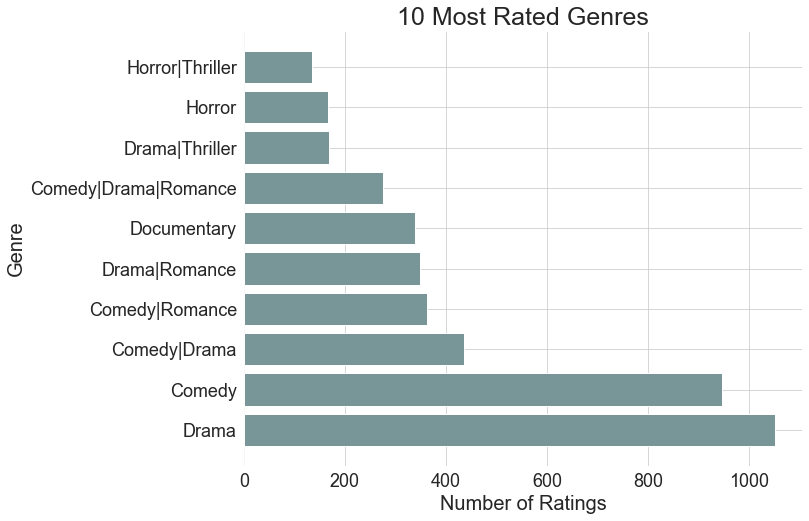

In [115]:
fig = plt.subplots(figsize=(10, 8))
plt.barh(most_rated_genre.index, most_rated_genre.title, color = '#789698')
plt.title('10 Most Rated Genres')
plt.xlabel('Number of Ratings')
plt.ylabel('Genre')
plt.savefig(parent_dir + 'reports/figures/top_10_genres.png')
plt.show();

So we can see here that `Drama` is the most highly rated genre, second is `Comedy` and third `Comedy|Drama`.  This along suggests that these could be aggregated some how and should be considered in future investigations.  

For now, I'll read out the df I have that dropped those duplicate rows:

In [120]:
movies_dropped = movies.to_csv(parent_dir + 'data/mod_movies')

### Time Series with `movies` and `ratings` dataframe:

As mentioned earlier, we kept the timestamp coloumn so we could investigate information about the timing of this data.  Let's explore that now by combining the ratings and movies dataframes.

In [107]:
movies['release_year'] = movies.title.apply(lambda x: x.strip()[-5:-1])
movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')

In [108]:
movies_ratings_joined = ratings.join(movies.set_index('movieId'), on='movieId').dropna()

In [109]:
movies_ratings_joined.head()

,userId,movieId,rating,timestamp,title,genres,release_year
0,1,1,4.0,1970-01-01 00:00:00.964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,1,3,4.0,1970-01-01 00:00:00.964981247,Grumpier Old Men (1995),Comedy|Romance,1995.0
2,1,6,4.0,1970-01-01 00:00:00.964982224,Heat (1995),Action|Crime|Thriller,1995.0
3,1,47,5.0,1970-01-01 00:00:00.964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995.0
4,1,50,5.0,1970-01-01 00:00:00.964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0


In [110]:
grouped = movies_ratings_joined.groupby('release_year')['rating'].mean()

In [111]:
grouproll = grouped.rolling(10).mean()
grouproll

release_year
1902.0         NaN
1903.0         NaN
1908.0         NaN
1915.0         NaN
1916.0         NaN
            ...   
2014.0    3.499127
2015.0    3.504148
2016.0    3.493029
2017.0    3.498531
2018.0    3.494070
Name: rating, Length: 106, dtype: float64

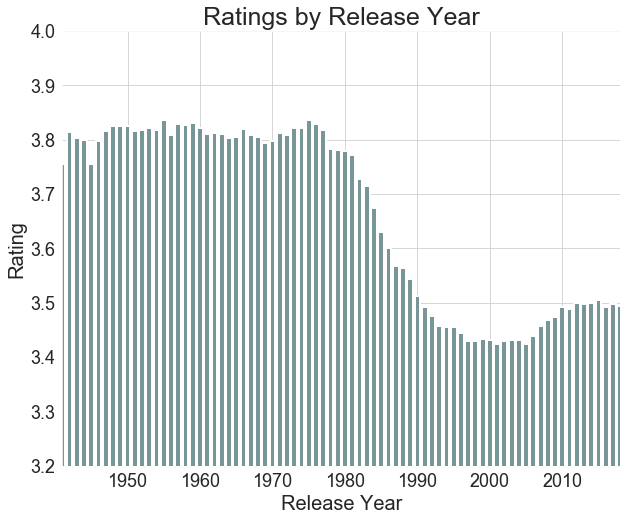

In [117]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(grouproll[1940:].index, grouproll[1940:], linewidth=2, color='#789698')
plt.title('Ratings by Release Year')
ax.set_ylim([3.2,4])
ax.set_ylabel('Rating')
ax.set_xlabel('Release Year')
ax.set_xlim([1941, 2018])
plt.savefig(parent_dir + 'reports/figures/ratings_by_release_date.png')
plt.show();

From this graph we can see that movies that were released before 1990 tend to have a higher average rating.  From roughly 1990, the average movie rating appears to trend downwards towards the average rating of the dataset (3.5).  Since the rating of these movies have taken place since 1993, this could suggest that people who watched and rated older movies, watched them because they were already a recommended to them as being good movies and so these movies are watched by good referral.  Whereas from 1993, movies could have been watched and rated by people's own motivations rather than personal recommendations.  So perhaps this suggests what we see in the data here.   

Since we didn't end up using the timestamp, let's drop it from our dataframe:

In [118]:
ratings.drop('timestamp', axis = 1, inplace = True)

Read this df out so it's accessible later:

In [119]:
ratings_model = ratings.to_csv(parent_dir + 'data/mod_ratings')

### Links Dataset

Let's get accquainted with the links dataset:

In [122]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [123]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
imdbId     9742 non-null int64
tmdbId     9734 non-null float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


It looks like there are going to be duplicates again given that there are the same number of `movieId`'s that the movies df had... so let's see if there are duplicate `imdbIds`:

In [124]:
len(links.movieId.unique())

9742

In [125]:
len(links.imdbId.unique())

9742

Ok no, doesn't look like there are duplicates.

Check the na's for tmdbId:

In [126]:
len(links.tmdbId.unique())

9734

In [127]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [128]:
links[links['tmdbId'].isna()]

,movieId,imdbId,tmdbId
624,791,113610,NaN
843,1107,102336,NaN
2141,2851,81454,NaN
3027,4051,56600,NaN
5532,26587,92337,NaN
5854,32600,377059,NaN
6059,40697,105946,NaN
7382,79299,874957,NaN


I think it's fine that we're missing tmdbIds since they shouldn't add much value to our modelling.  

Overall, the `links` dataset will be useful for webscraping if we want to get images from IMDB for the movies to add to deployment methods but it won't add any value to our models.  

### Tags Dataset

Let's get accquainted with the tags dataset:

In [130]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [131]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


No null rows.

In [132]:
print(f"Number of users who provided tags:  {len(tags.userId.unique())}")

Number of users who provided tags:  58


In [133]:
print(f"Number of unique movies with tags:  {len(tags.movieId.unique())}")

Number of unique movies with tags:  1572


In [134]:
print(f"Number of unique tags:  {len(tags.tag.unique())}")

Number of unique tags:  1589


So while there are 3683 entries, there are only 1589 unique tags so we do have some common tags - might be worth finding the top 10-20 most common tags perhaps?

Only 1572 movies have been tagged so if we join these dfs, most will have na values (which is fine).

Only 58 users actually added tags.  This is quiet a small subset of our overall users.

We probably don't need the timestamp column for this dataset.

In [135]:
tags.drop('timestamp', axis = 1, inplace = True)

Let's look into the most common tags and find the top 20 tags.

In [136]:
count_tags = {}
for tag in tags['tag']:
    count_tags[tag] = count_tags.get(tag, 0) + 1

In [137]:
popular_tag = []
for tag in count_tags:
    if count_tags[tag] > 0:
        popular_tag.append(tag)

In [138]:
sorted_pop_tags = sorted(popular_tag, key=lambda x:x[1], reverse=True)

In [139]:
sorted_pop_tags[:20]

['cyberpunk',
 'Mystery',
 'Ryan Reynolds',
 'dystopia',
 'ryan reynolds',
 'Dystopia',
 'system holism',
 'mystery',
 'cynical',
 'mythology',
 'Myth',
 'lyrical',
 'symbolism',
 'symbolic',
 'Exquisite plotting.',
 'ex-con',
 'existentialism',
 'Existential',
 'exciting',
 'twist ending']

We can see there's a lot of double ups here with tags that do and don't use capitilisation such asa 'Ryan Reynolds' vs. 'ryan reynolds'.  As well as similar categories such as 'myth', 'mythology', even 'mystery'.  

Perhaps we could perform some NLP pre-processing on this data to make more consistent tags.  This might not be completely neccessary since it's such a small set of the data that is tagged (only 3000 amongst 100k movie ratings) but something we could experiment with.  

I won't do any of the NLP processing now, but we know it exists and I will export the csv without the timestamp.

In [140]:
tags_model = tags.to_csv(parent_dir + 'data/mod_tags')

# Join the dataframes:

The `ratings` df has over 100k rows, and then `movies` df has just under 10k rows.  So let's first try joining the `ratings` and `movies` dfs together using `movieId` as the key.  We will left join on `ratings`.

First, we'll check the shape of both dfs to be able to compare the joined result.  

In [141]:
ratings.shape

(100836, 3)

In [142]:
movies.shape

(9737, 4)

In [143]:
movie_ratings = ratings.set_index('movieId').join(movies.set_index('movieId'))

In [144]:
movie_ratings.head()

,userId,rating,title,genres,release_year
movieId,,,,,
1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0


This is looking like our desired result.  Let's check the shape:

In [145]:
movie_ratings.shape

(100836, 5)

So we have not lost rows - this is what we expect. 

In [146]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 1 to 193609
Data columns (total 5 columns):
userId          100836 non-null int64
rating          100836 non-null float64
title           100816 non-null object
genres          100816 non-null object
release_year    100799 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.6+ MB


From here we can see that there are 20 movies that we do not know the title or genre for.  Let's see what these movies are:

In [147]:
movie_ratings[movie_ratings['title'].isna()]

,userId,rating,title,genres,release_year
movieId,,,,,
6003,111,4.0,NaN,NaN,NaN
6003,156,3.5,NaN,NaN,NaN
6003,182,3.0,NaN,NaN,NaN
6003,288,4.0,NaN,NaN,NaN
6003,356,4.5,NaN,NaN,NaN
6003,387,3.5,NaN,NaN,NaN
6003,414,3.5,NaN,NaN,NaN
6003,474,3.5,NaN,NaN,NaN
6003,480,3.5,NaN,NaN,NaN


From here, out of the 20 that do not have titles or genres, there are actually only 5 movies that are missing their title.  We could pair this with the links df and look up the title and genre on IMDB and manually add this in since it's only 5 records.  This might be worth it since movie 6003 has 15 ratings that we don't know the name of (and hence can't recommend the name in our app). 

Let's now join the links df with this df, again with the movie id as the key:

In [148]:
links.shape

(9742, 3)

In [149]:
movie_rating_links = movie_ratings.join(links.set_index('movieId'))

In [150]:
movie_rating_links.head()

,userId,rating,title,genres,release_year,imdbId,tmdbId
movieId,,,,,,,
1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,114709,862.0
1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,114709,862.0
1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,114709,862.0
1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,114709,862.0
1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,114709,862.0


In [151]:
movie_rating_links.shape

(100836, 7)

No info loss! 

Let's have a look at those movies that didn't have titles:

## Summary 

Overall, our datasets are pretty clean.  There are definitely areas that will need to be addressed in our modelling such as adding regularisation to account for the long tail problem as well as doing some NLP processing to deal with the genres data for doing content-based models.  